<a href="https://colab.research.google.com/github/deangarcia/NLP/blob/main/NaiveBayesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This implementation of the naive bayes is being used to identify whether a poem is of one of the given classes: **Love, Nature, Mythology/Folklore**. One of our main goals was to compare this classification model with GPT2. With the Naive Bayes approach, we felt like we were able to understand the characteristics that really affected the overall performance for this corpus.

Install Datasets to load in from huggyface and load in all packages.

In [ ]:
!pip install datasets 
from datasets import load_dataset
dataset = load_dataset("merve/poetry")

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from spacy.lang.en import English

Now we have the corpus list which is just a list of full text so that we can utilize sklearn and build our vocabulary from the original corpus. Sklearn Count Vectorizer has an array of uses but we chose to use this package so we can take advantage of the built in minimum and maximum frequency thresholds for word occurences in our vocabulary and the built-in tokenizer.

In [158]:
corpus = {}
test_corpus = {}
vocab_corpus = []

split_count = 0
for group in dataset:
  for attributes in dataset:
    for content in dataset[attributes]:
      if split_count % 5 == 0:
        test_corpus[str(content['content']) + " " + str(content['author']) + " " + str(content['poem name'])] = str(content['type'])
      else:
        corpus[str(content['content']) + " " + str(content['author']) + " " + str(content['poem name'])] = str(content['type'])

      vocab_corpus.append(str(content['content']) + " " + str(content['author']) + " " + str(content['poem name']))
      split_count += 1

vectorizer = CountVectorizer(min_df=0, max_df=0.45, lowercase = True) 
X = vectorizer.fit(vocab_corpus) 
vocab = vectorizer.get_feature_names_out()

Here we are going through the dataset and using spacy to tokenize the class corpus as a list of lists where each entry in one of the lists are the tokens so that we can do ngrams and cooccurrences. We also weed out common and infrequent words based off our vocab from the previous step.

In [159]:
love_corpus = []
nature_corpus = []
myth_corpus = []

love_prob = 0.0
nature_prob = 0.0
myth_prob = 0.0

nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

for key in corpus:
  temp = []
  tokens = tokenizer(key)

  for token in tokens:
    word = token.lemma_.lower()
    if word in vocab:
      temp.append(word)

  if corpus[key] == "Love":
    love_prob += 1.0
    love_corpus.append(temp)
  elif corpus[key] == "Nature":
    nature_prob += 1.0
    nature_corpus.append(temp)
  else:
    myth_prob += 1.0
    myth_corpus.append(temp)


Tester function so we can see what we will be passing into word counts

---



In [160]:
print(len(myth_corpus))

27


In [161]:
count = 0
for word in love_corpus:
  if count < 5:
    count+= 1
    print(word)

['long', 'have', 'longd', 'see', 'love', 'againe', 'still', 'have', 'wisht', 'never', 'could', 'obtaine', 'it', 'rather', 'than', 'world', 'if', 'might', 'gaine', 'it', 'would', 'desire', 'loves', 'sweet', 'precious', 'gaine', 'yet', 'soule', 'see', 'him', 'everie', 'day', 'see', 'him', 'see', 'his', 'still', 'sterne', 'countenaunce', 'ah', 'what', 'long', 'continuance', 'where', 'majestie', 'beautie', 'beares', 'sway', 'sometimes', 'when', 'imagine', 'see', 'him', 'as', 'love', 'full', 'foolish', 'fantasies', 'weening', 'kisse', 'his', 'lips', 'as', 'loves', 'fees', 'feele', 'aire', 'nothing', 'aire', 'bee', 'him', 'thus', 'ixion', 'kisse', 'clouds', 'vaine', 'thus', 'ixion', 'feele', 'endles', 'paine', 'richard', 'barnfield', 'sonnet', '16']
['when', 'was', 'fair', 'young', 'then', 'favor', 'graced', 'me', 'many', 'was', 'sought', 'their', 'mistress', 'be', 'did', 'scorn', 'them', 'answered', 'them', 'therefore', 'go', 'go', 'go', 'seek', 'some', 'other', 'where', 'importune', 'me', 

One issue we ran into was an imbalanced set of data between the classes. That is there were a lot more love poems than nature or mythology and folkore, so we used a stragedy called oversampling to rectify this issue. We sumized that the reason this was an issue was because the more samples of one class the higher the counts for words even the commonly used ones which gives it an advantage over others. However, there is a trade off because with oversampling we will get double counts for whichever words are associated with the randomly re-sampled poem. So, in some cases even with a smaller dataset a class that was highly oversampled would start to gain an advantage over others. So, we created the function below to oversample based off the percentage of the total poems a class takes up. If it is higher than the threshold the function resamples a random poem from the underrepresented class and tries to close the distance for the number of poems per class.

In [162]:
def imbalanced(total, type_count, balance_percentage):
  still_imbalanced = True

  # error cant split 3 in equal parts less than .33
  if len(type_count) / 100 > balance_percentage:
    return False

  for count in type_count:
    if (count / total) > balance_percentage:
      return True
    else:
      still_imbalanced = False

  return still_imbalanced

In [163]:
import random

corpus_count = len(corpus)
while imbalanced(corpus_count, [love_prob, nature_prob, myth_prob], 0.55):
  if love_prob >= nature_prob:
    nature_corpus.append(nature_corpus[random.randint(0, len(nature_corpus) - 1)])
    nature_prob += 1.0
  if love_prob >= myth_prob:
    myth_corpus.append(myth_corpus[random.randint(0, len(myth_corpus) - 1)])
    myth_prob += 1.0
  if nature_prob >= love_prob:
    love_corpus.append(love_corpus[random.randint(0, len(love_corpus) - 1)])
    love_prob += 1.0
  if nature_prob >= myth_prob:
    myth_corpus.append(myth_corpus[random.randint(0, len(myth_corpus) - 1)])
    myth_prob += 1.0
  if myth_prob >= nature_prob:
    nature_corpus.append(nature_corpus[random.randint(0, len(nature_corpus) - 1)])
    nature_prob += 1.0
  if myth_prob >= love_prob:
    love_corpus.append(love_corpus[random.randint(0, len(love_corpus) - 1)])
    love_prob += 1.0
  corpus_count = love_prob + nature_prob + myth_prob


Test function so we can see how tweaking our parameters effects the count and percentages each class has on the dataset of poems

In [164]:
print(love_prob)
print(nature_prob)
print(myth_prob)

love_prob = love_prob/corpus_count
nature_prob = nature_prob/corpus_count
myth_prob = myth_prob/corpus_count

print(love_prob)
print(nature_prob)
print(myth_prob)

261.0
146.0
69.0
0.5483193277310925
0.3067226890756303
0.14495798319327732


This function is similar to the function done in assignment one here we can get the counts for words grouped up with each other

In [165]:
def get_counts(input_corpus,n):
  ngrams = {}
  #Text is a list of lists
  for word in input_corpus:
    # iterate through each list (-n + 1 because of the nested for loop we dont want to go out of range and len(array) doesnt take into account 0)
    for i in range(len(word) - n + 1):
      temp = [] 
      # now iterate through the list j values which is the length of n to save our string values into a tuple
      for j in range(n):
        temp.append(word[i+j])
      tuple_temp = tuple(temp)
      # save the tuple as a key at increment it by one if it exists already 
      if tuple_temp in ngrams.keys():
        ngrams[tuple_temp] += 1
      # or set it to one on the first occurence
      else:
        ngrams[tuple_temp] = 1

  return ngrams


Here we set up what level gram we want to text on

In [166]:
love_unigrams = get_counts(love_corpus,1)
love_bigrams = get_counts(love_corpus,2)

nature_unigrams = get_counts(nature_corpus,1)
nature_bigrams = get_counts(nature_corpus,2)

myth_unigrams = get_counts(myth_corpus,1)
myth_bigrams = get_counts(myth_corpus,2)

Another tester function to see the distribution of grams or words have on each corpus. Here we can see a higher diversity of keys in the higher level gram which increases the count therby decreasing the overall effect a key has on the probability. So in all the lower the diversity of words the more advantage it has in the class scoring

In [167]:
import collections 

print(len(love_unigrams))
print(len(nature_unigrams))
print(len(myth_unigrams))

od1 = collections.OrderedDict(sorted(love_unigrams.items(), key=lambda item: item[1], reverse=True))
print(od1)
od2 = collections.OrderedDict(sorted(nature_unigrams.items(), key=lambda item: item[1], reverse=True))
print(od2)
od3 = collections.OrderedDict(sorted(myth_unigrams.items(), key=lambda item: item[1], reverse=True))
print(od3)

6075
4626
3637
OrderedDict([(('love',), 440), (('her',), 381), (('me',), 348), (('not',), 340), (('you',), 308), (('be',), 295), (('it',), 292), (('as',), 282), (('so',), 275), (('his',), 236), (('thy',), 226), (('which',), 225), (('thou',), 216), (('this',), 197), (('she',), 187), (('have',), 181), (('when',), 179), (('your',), 164), (('or',), 162), (('do',), 161), (('no',), 153), (('on',), 147), (('we',), 143), (('will',), 142), (('he',), 130), (('now',), 130), (('then',), 129), (('one',), 129), (('shall',), 126), (('they',), 125), (('if',), 124), (('more',), 123), (('are',), 123), (('at',), 122), (('can',), 121), (('thee',), 121), (('like',), 120), (('eyes',), 119), (('yet',), 117), (('doth',), 117), (('was',), 115), (('what',), 113), (('who',), 105), (('heart',), 103), (('their',), 100), (('did',), 99), (('fair',), 98), (('may',), 98), (('our',), 91), (('nor',), 89), (('such',), 86), (('let',), 85), (('see',), 81), (('where',), 81), (('there',), 81), (('hath',), 81), (('still',), 8

This function will take in a new poem and classify it based on the corpus counts. We did notice here that the grams higher than 1 are always more inaccurate I think the safest bet is to say that the nature and mythology sets have more common words as we can sort of see from the ordered test data above

In [168]:
def get_class(poem_list, n):
  classified = {}
  count = 0
  
  love_grams = get_counts(love_corpus,n)

  nature_grams = get_counts(nature_corpus,n)

  myth_grams = get_counts(myth_corpus,n)

  for poem in poem_list:
    love = 1.0
    nature = 1.0
    myth = 1.0

    temp = []
    tokens = tokenizer(poem)

    for token in tokens:
      word = token.lemma_.lower()
      if word in vocab:
        temp.append(word)

    temp_dict = get_counts([temp],n)

    for key in temp_dict:
      if key in love_grams:
        love *= (love_grams[key] + 1)/len(love_grams)
      if key in nature_grams:
        nature *= (nature_grams[key] + 1)/len(nature_grams)
      if key in myth_grams:
        myth *= (myth_grams[key] + 1)/len(myth_grams)

    love *= love_prob
    nature *= nature_prob
    myth *= myth_prob

    temp_list = [love, nature, myth]
    classified["Poem " + str(count)] = temp_list
    count+= 1
    
  return classified

In [169]:
import pandas as pd
pd.set_option("display.max_colwidth", 10000)
url = 'https://raw.githubusercontent.com/deangarcia/NLP/main/kaggle_poem_dataset.csv'
df1 = pd.read_csv(url)

df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]
df1.drop("Poetry Foundation ID", axis=1, inplace=True)
subset_500 = df1.loc[0:500]
poem_arr = []
count = 0

for i in range(len(subset_500)):
  temp_row_string = subset_500.loc[i].to_string(index=False)
  poem_arr.append(temp_row_string)


In [170]:
random_poem_result_dict = get_class(poem_arr, 1)
og_corpus_result_dict = get_class(test_corpus, 1)
random_poem_result_bi_dict = get_class(poem_arr, 2)
og_corpus_result_bi_dict = get_class(test_corpus, 2)


In [171]:
def get_graph_results(result_dict):
  love_pred = 0
  nature_pred = 0 
  myth_pred = 0
  for result in result_dict:
    values = result_dict[result]
    greatest = 0
    
    for val in values:
      if val > greatest:
        greatest = val
  
    if greatest == values[0]:
      love_pred += 1

    if greatest == values[1]:
      nature_pred += 1

    if greatest == values[2]:
      myth_pred += 1
  return love_pred, nature_pred, myth_pred

Even putting the original corpus here we get a higher rate of mythology our thoughts are that the corpus with the highest number of common words will have the advantage since the classes with repeating unique words will drown out the common words from their own corpus, but if a class has a highly associated word like love in the love class it will be easier to identify or maybe even misclassify depending on the text. 

These are random unclassified poems just to show the bias toward one class.

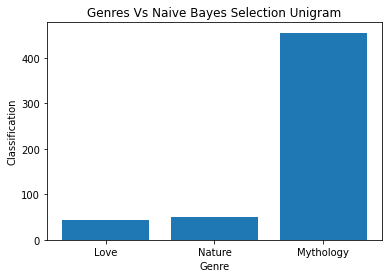

In [172]:
from operator import and_
import matplotlib.pyplot as plt

love_pred, nature_pred, myth_pred = get_graph_results(random_poem_result_dict)

Genre = ['Love','Nature','Mythology']
Classifications = [love_pred,nature_pred,myth_pred]

plt.bar(Genre, Classifications)
plt.title('Genres Vs Naive Bayes Selection Unigram')
plt.xlabel('Genre')
plt.ylabel('Classification')
plt.show()

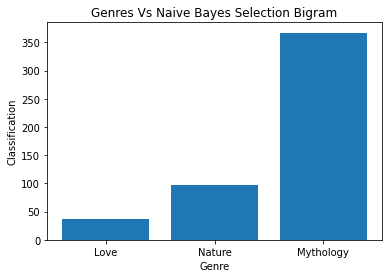

In [173]:
from operator import and_
import matplotlib.pyplot as plt

love_pred, nature_pred, myth_pred = get_graph_results(random_poem_result_bi_dict)

Genre = ['Love','Nature','Mythology']
Classifications = [love_pred,nature_pred,myth_pred]

plt.bar(Genre, Classifications)
plt.title('Genres Vs Naive Bayes Selection Bigram')
plt.xlabel('Genre')
plt.ylabel('Classification')
plt.show()

In [176]:

def accuracy_results(n):
  right = 0
  wrong = 0
  for key in test_corpus:
    class_results = get_class(key, n)
    genre = ""
    for result in class_results:
      values = class_results[result]
      greatest = 0
      
      for val in values:
        if val > greatest:
          greatest = val
    
      if greatest == values[0]:
        genre = "Love"

      if greatest == values[1]:
          genre = "Nature"

      if greatest == values[2]:
          genre = "Mythology & Folklore"

    if test_corpus[key] == genre:
      right += 1
    else:
      wrong += 1
  return right, wrong

In [177]:
unigram_right, unigram_wrong = accuracy_results(1)
bigram_right, bigram_wrong = accuracy_results(2)

0.5701754385964912


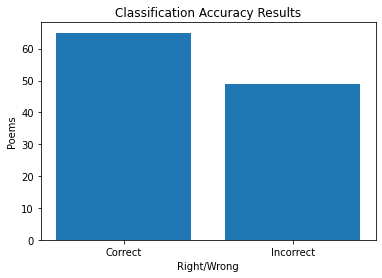

In [178]:
from operator import and_
import matplotlib.pyplot as plt

print(unigram_right/(unigram_right+unigram_wrong))

Results = ['Correct','Incorrect']
Counts = [unigram_right, unigram_wrong]

plt.bar(Results, Counts)
plt.title('Classification Accuracy Results')
plt.xlabel('Right/Wrong')
plt.ylabel('Poems')
plt.show()

0.5701754385964912


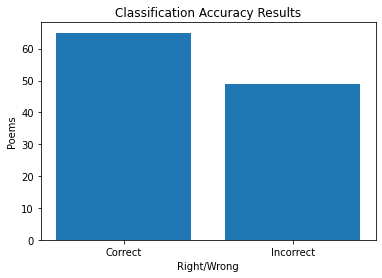

In [179]:
from operator import and_
import matplotlib.pyplot as plt

print(bigram_right/(bigram_right+bigram_wrong))

Results = ['Correct','Incorrect']
Counts = [bigram_right, bigram_wrong]

plt.bar(Results, Counts)
plt.title('Classification Accuracy Results')
plt.xlabel('Right/Wrong')
plt.ylabel('Poems')
plt.show()

In [106]:
list_new_poems = ["William Shakespeare", "William Shakespeare O Mistress Mine O Mistress mine, where are you roaming? O, stay and hear; your true love's coming, That can sing both high and low: Trip no further, pretty sweeting; Journeys end in lovers meeting, Every wise man's son doth know. What is love? 'Tis not hereafter; Present mirth hath present laughter; What's to come is still unsure: In delay there lies not plenty; Then, come kiss me, sweet and twenty, Youth's a stuff will not endure.", "Your cuteness knows no bounds, your beauty has no limit, you are the only woman in the world, to which I will commit. I look at you and gasp in awe, wondering how you’re mine, you take my breath away my dear, for you, I’ll walk the line.", "My angel, my life, my entire world, please be with me always, my one and only girl. I love you so deeply, that I know is so true, for there is no one else, my heart beats just for you. No matter what happens, you’re always the one, that I want to come home to, I’m the Earth to your sun.", "Whose woods these are I think I know. His house is in the village though; He will not see me stopping here To watch his woods fill up with snow. My little horse must think it queer To stop without a farmhouse near Between the woods and frozen lake The darkest evening of the year. He gives his harness bells a shake To ask if there is some mistake. The only other sound’s the sweep Of easy wind and downy flake. The woods are lovely, dark and deep, But I have promises to keep, And miles to go before I sleep, And miles to go before I sleep."]
get_class(list_new_poems, 2)

{'Poem 0': [0.0009202476634438457,
  0.0002920512889637386,
  3.120960520490709e-05],
 'Poem 1': [2.007212439667951e-264,
  1.4125567933423176e-31,
  1.2262830809329038e-28],
 'Poem 2': [8.156074296397679e-51,
  1.2136484593455583e-25,
  7.986635798358515e-18],
 'Poem 3': [4.618760564878688e-33,
  3.710657345541483e-20,
  6.289875022997249e-14],
 'Poem 4': [1.1085025355708847e-33,
  3.387300111558067e-28,
  8.984965273153329e-17]}